In [46]:
# Load all packages
from os.path import join
import mat73
%matplotlib inline
%gui qt
import matplotlib.pyplot as plt
import numpy as np
import mne
from tqdm import tqdm # For progress bar
# For moving average... not sure if good
from scipy.ndimage import uniform_filter1d

In [31]:
# Load data into dictionary
DataPath = join("neuro_data","dataSubj10.mat")
data_dict = mat73.loadmat(DataPath, use_attrdict=True)
data = data_dict["data"]

In [126]:
# Function to transform data to appropriate shape

def DimConvertFunc(trial, all_channels, bad_channels, n_samples):
    """Converts 60 channel data to 74 channel data with dummy info, in order to fit EasyCap format.

    Args:
        trial (array of floats): data from channel
        moving_window (int, optional): moving average window to smoothen data for visualization. Defaults to 0.

    Returns:
        _type_: _description_
    """
    newTrial = np.zeros((len(all_channels),n_samples))
    j = 0
    filler = [0]*n_samples
    for i, ch in enumerate(all_channels):
        if ch in bad_channels:
            newTrial[i]=filler
        else:
            newTrial[i]=trial[j]/(10**6) # Divide with ~10**6 to convert muV to V
            j += 1
    return newTrial

In [127]:
def create_MNE_events(trialinfo):
    """Create event data structure with MNE compatible format from data["trialinfo"]

    Args:
        trialinfo (_type_): data["trialinfo"] as provided in the MatLab data from M. Sandsten.

    Returns:
        _type_: MNE compatible event data structure
    """

    n = len(trialinfo)
    metadata = [0]*n
    for i, trialinfo in enumerate(trialinfo):
        # side : left = 1, right = 2
        # side_accuracy : Correct (1) Incorrect (2) No response (3) Almost correct (4)
        metadata[i] = {"side":int(trialinfo[0]["side"]),"accurate":int(trialinfo[0]["side_accuracy"])}

    event_label = [event["side"] for event in metadata] # actual info, must be converted to shape (N,3)
    events = np.zeros((n,3))
    events[:,2] = np.array(event_label)  #Add labels to 3rd column, 2nd column irrelevant, but shape needed
    events[:,0] = np.array(range(n))     #Add dummy IDs to first column
    events = events.astype(int)
    return events

In [167]:
def create_MNE_EpochsArray(data):
    # Constants
    sfreq = data["fsample"] # Sampling frequency
    used_channels = [ch[0].upper() for ch in data["label"]]
    all_channels = [ch[0] for ch in data["elec"]["label"]] # Not all upper case
    used_channel_case = [ch for ch in all_channels if ch.upper() in used_channels] # match cases
    bad_channels = list(set(all_channels).difference(set(used_channel_case))) # Channels not used
    n_samples = len(data["trial"][0][0]) # Amount of measurements for each channel in a trial

    # MNE data structures

    info = mne.create_info(all_channels, sfreq, "eeg")
    info.set_montage('easycap-M1')
    info["bads"] = bad_channels

    events = create_MNE_events(data["trialinfo"])
    event_dict = {"auditory/left":1, "auditory/right":2}

    # Create array with 74 instead of 60 channel data to fit Easycap Scheme
    rawdata_UpScaledDim = np.array([DimConvertFunc(epoch, all_channels, bad_channels, n_samples) for epoch in data["trial"]])
    epochs = mne.EpochsArray(rawdata_UpScaledDim, info, tmin=-2, events=events, event_id=event_dict, baseline=(-2,0))
    return epochs, used_channel_case, bad_channels, events, event_dict

In [168]:
epochs, used_channels, bad_channels, events, event_dict = create_MNE_EpochsArray(data)

Not setting metadata
352 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


# Sensor Visualizations

For some reason plotting doesn't function as intended, no titles are working, and plotting in grid doesn't work. 

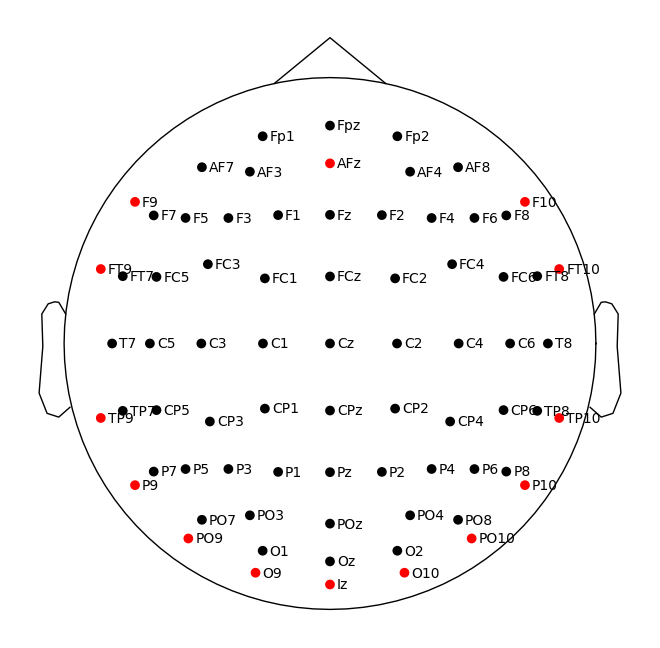

In [81]:
# Topologigal map - 2d sensor plot
epochs.plot_sensors(kind="topomap", ch_type="eeg", show_names=True)
plt.close()

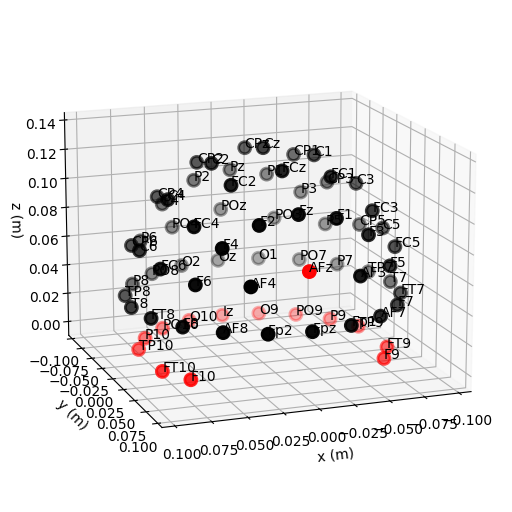

In [82]:
# 3D Sensor Locations
fig = epochs.plot_sensors(kind="3d", ch_type="eeg", show_names=True, show=False, title="Sensor Locations 3D")
fig.gca().view_init(azim=70, elev=15)

# Epoch visualizations

First I visualize the raw data from the first sample. 
Here we group electrodes from the same region to fit all on one plot.

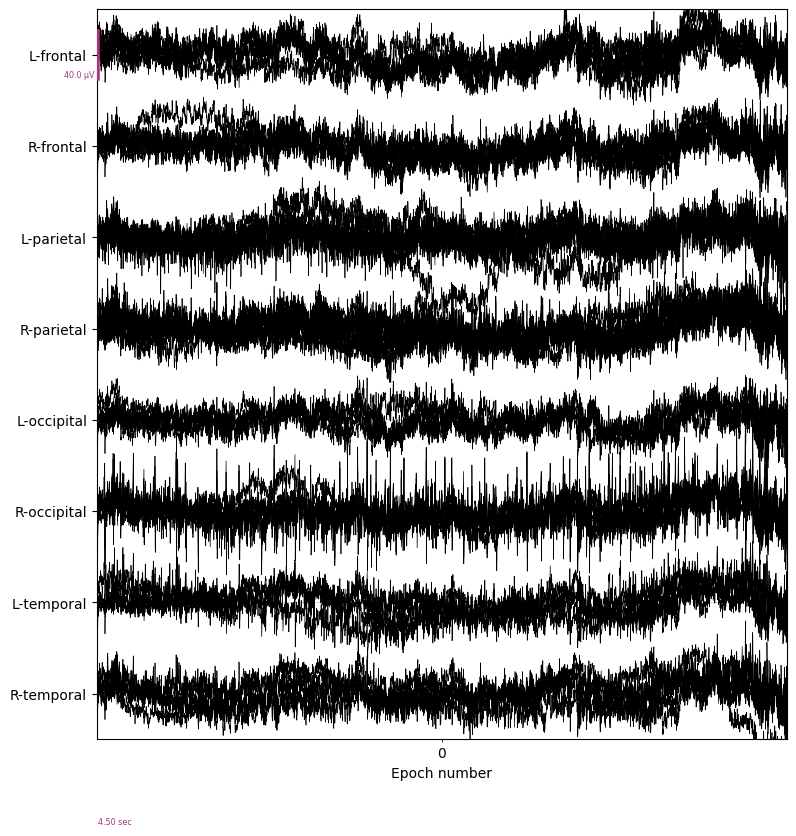

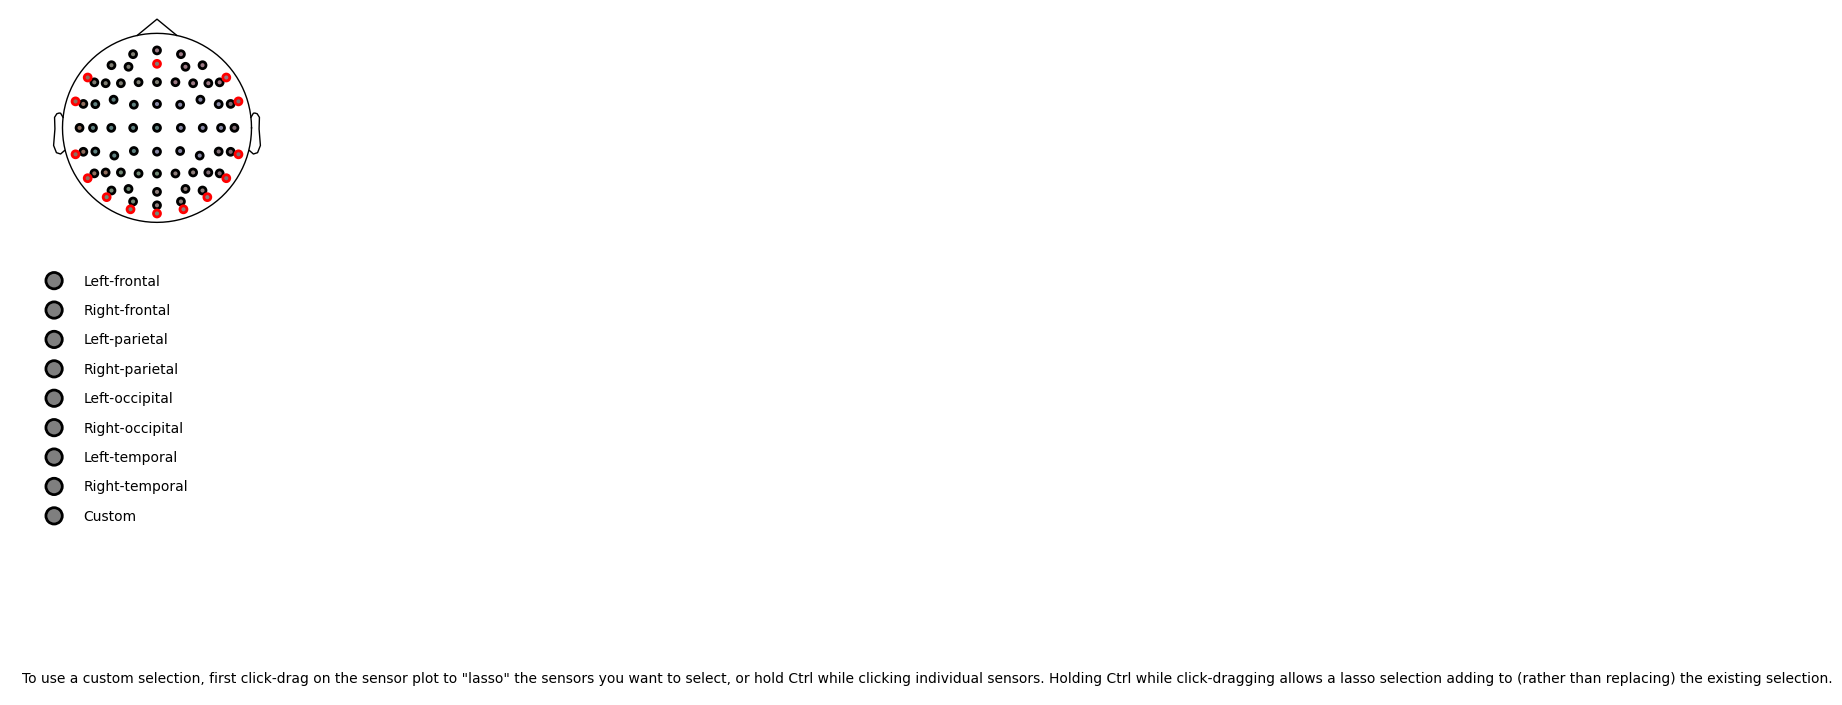

In [159]:
# Change scaling to fit 
val = 2e-5
scaling = dict(mag=val, grad=val, eeg=val, eog=val, ecg=val,
     emg=val, ref_meg=val, misc=val, stim=val,
     resp=val, chpi=val, whitened=val)

fig = epochs[0].plot(scalings=scaling, group_by="position", butterfly=True, show_scrollbars=False)

Power Spectral Density plots

    Using multitaper spectrum estimation with 7 DPSS windows


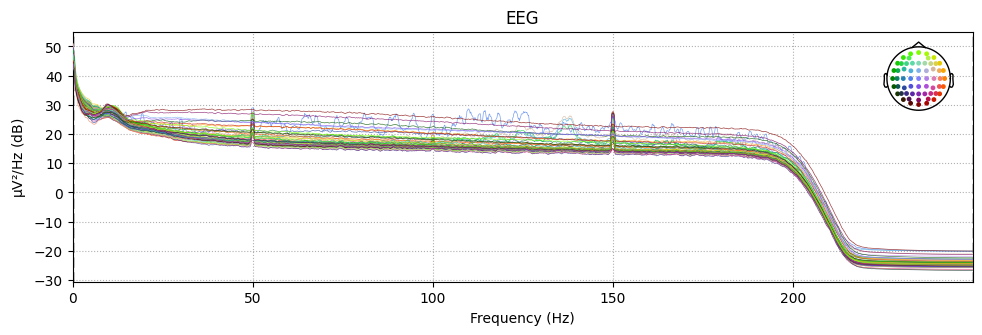

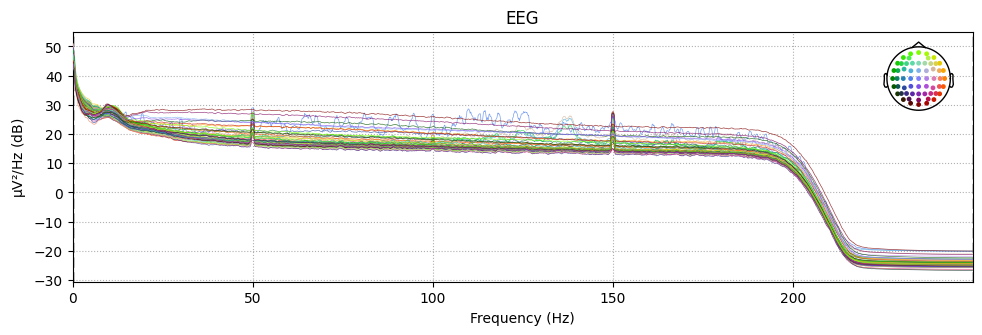

In [160]:
# See Nyquist criterion
epochs.plot_psd()
plt.close()

    Using multitaper spectrum estimation with 7 DPSS windows


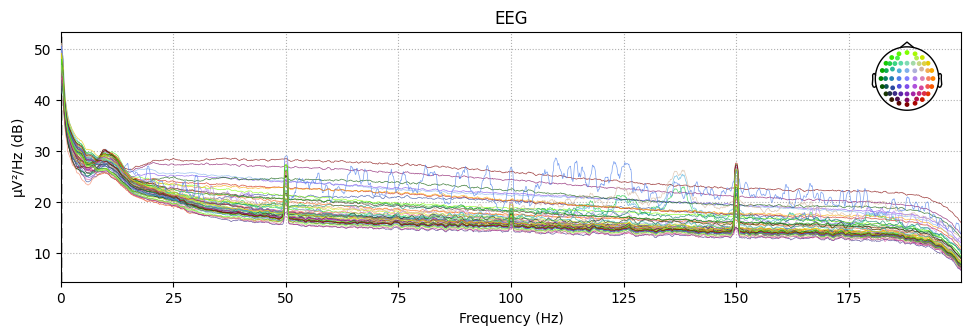

In [161]:
# Note 1/f noise here
epochs.plot_psd(fmax=200)
plt.close()

    Using multitaper spectrum estimation with 7 DPSS windows


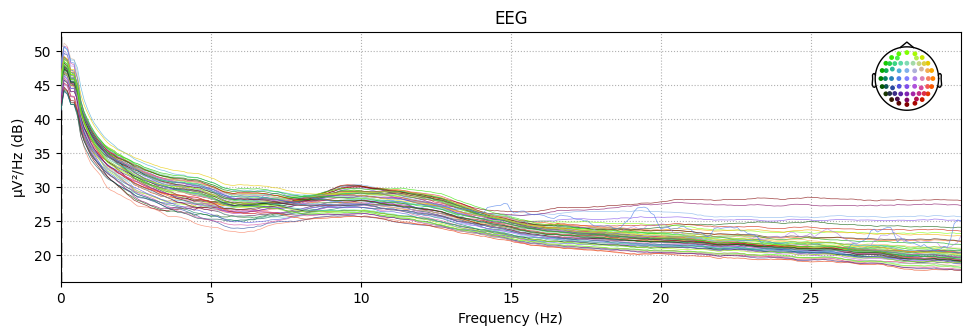

In [164]:
# Region of interest
epochs.plot_psd(fmax=30)
plt.close()

# Evoked Visualization

In [169]:
# Create evoked data
evoked_tot = epochs.average()
evoked_left = epochs["auditory/left"].average()
evoked_right = epochs["auditory/right"].average()

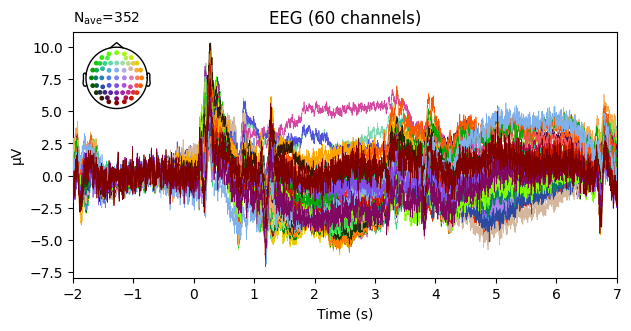

In [174]:
# Not at all smooth, which is strange, as noise should be cancelled out by averaging.
evoked_tot.plot(picks="eeg",spatial_colors=True)
plt.close()

In [202]:
def smoothen_helper(data):
    # Wrapper to have only one argument
    window = 20
    return uniform_filter1d(data, window)

def smoothen(data):
    # Input noisy evoked array, outputs smoothened evoked array
    return data.apply_function(smoothen_helper, picks="eeg")

Smoothened butterfly plots for total, left and right

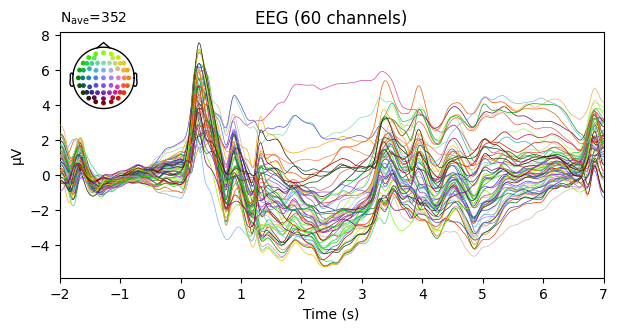

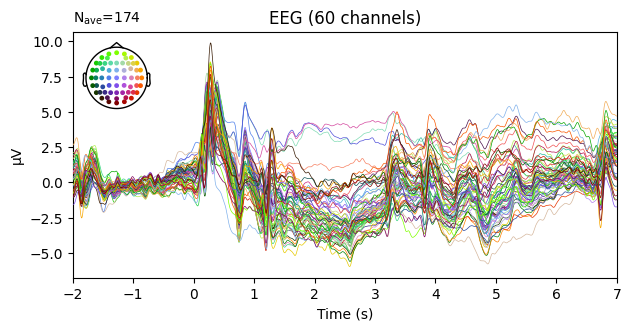

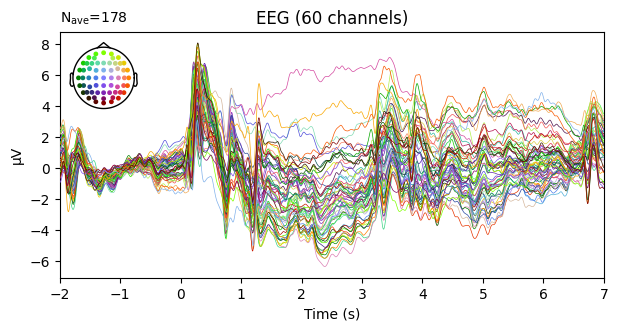

In [203]:
s_evo = smoothen(evoked_tot)
s_evo_l = smoothen(evoked_left)
s_evo_r = smoothen(evoked_right)
s_evo.plot(picks="eeg",spatial_colors=True)
s_evo_l.plot(picks="eeg",spatial_colors=True)
s_evo_r.plot(picks="eeg",spatial_colors=True)
plt.close()

Topomaps for left and right evokeds

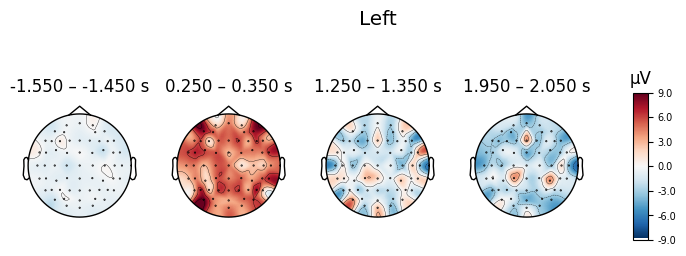

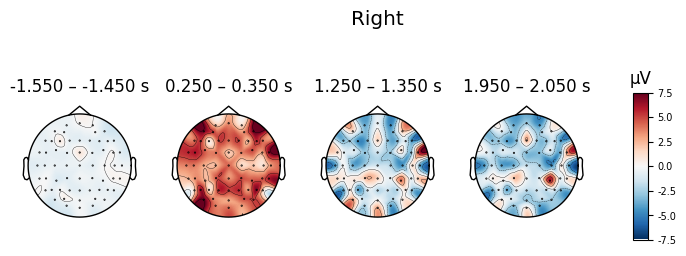

No projector specified for this dataset. Please consider the method self.add_proj.


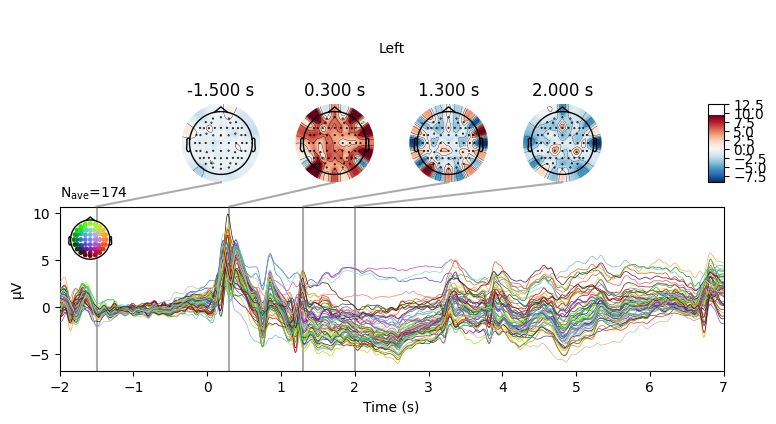

No projector specified for this dataset. Please consider the method self.add_proj.


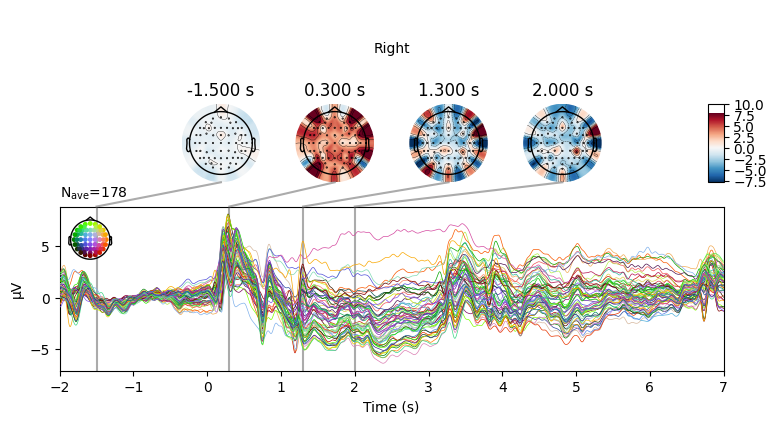

In [215]:
times = np.array([-1.5,0.3,1.3,2])
s_evo_l.plot_topomap(times=times, ch_type="eeg",colorbar=True,average=0.1, title="Left")
s_evo_r.plot_topomap(times=times, ch_type="eeg",colorbar=True,average=0.1, title="Right")
s_evo_l.plot_joint(times=times, title="Left")
s_evo_r.plot_joint(times=times, title="Right")
plt.close()

Create plots with xlim only in region of interest

# Demo Time-Frequency Representation

In [39]:
freqs = np.logspace(*np.log10([1,30]), num=200) # Frequencies of interest for spectrogram
n_cycles = freqs / 1.  # Why this choice?
power = mne.time_frequency.tfr_morlet(epochs[0], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False)

#fig = power.plot(['Oz'], baseline=(-2,0), mode="logratio", title='Oz', tmin=0, tmax=4, cmap="binary_r")
# Save only image part 
# https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content


#fig[0].savefig("test.png", bbox_inches='tight')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.8s finished


# Prepare images for ML

Save pure TFR images, with some compression.

In [40]:
def GenerateTFRHelper(epoch, channels, freqs, n_cycles, savepath, decim=3):
    """ Generates Time-Frequency representation for given channels of EEG data.clear.
        Images are generated without axes or anything obsolete, only the TFR is saved.

    Args:
        epoch (_type_): The sample for which to create spectrograms
        channels (_type_): List of channels names for which spectrograms are desired
        freqs (_type_): Array of desired frequencies
        n_cycles (_type_): ???
        savepath (_type_): Path to folder where images will be saved
        decim (int, optional): Down-sampling factor to speed up calculation. Defaults to 3.
    """
    power = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=decim)
    for ch in channels:
        fig, ax = plt.subplots(1,1)
        plt.axis('off')
        power.plot([ch], baseline=(-2,0), mode="logratio", tmin=0, tmax=4, cmap="binary_r", axes=ax, colorbar=False, show=False, verbose=False)
        fig.savefig(savepath+ch+".png",bbox_inches='tight',pad_inches=0)
        plt.close()

In [41]:
def GenerateTFR(channels, resolution = 10):

    freqs = np.logspace(*np.log10([1,30]), num=resolution) # Frequencies of interest for spectrogram
    n_cycles = freqs / 1.  # Why this choice?
    savepath = "TFR_Plots/"
    for i in tqdm(range(len(epochs))):
        GenerateTFRHelper(epochs[i],channels, freqs, n_cycles, savepath+str(i)+"_")

channels = ["T7","T8"]
# GenerateTFR(channels, resolution=100)